<a href="https://colab.research.google.com/github/ta3h30nk1m/Neural_Style_Transfer_Practice/blob/main/NST_variable_variation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From the codes from NST_tutorial, want to see what will change if we decide different values for each hyperparameters

how to import functions from colab file: https://codingalone.tistory.com/2

https://stackoverflow.com/questions/20186344/importing-an-ipynb-file-from-another-ipynb-file

In [ ]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (24, 24)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

from google.colab import drive
drive.mount('/content/gdrive')
content_path = '/content/gdrive/MyDrive/Neural_Style_Transfer/images/contents/cane.jpg/'
style_path = '/content/gdrive/MyDrive/Neural_Style_Transfer/images/styles/brightNight.jpeg/'

def load_img(path_to_img):
  max_dim = 512  # 이미지 최대 크기
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape*scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  
  plt.imshow(image)
  if(title):
    plt.title(title)

content_image = load_img(content_path)
style_image = load_img(style_path)

content_layers = ['block5_conv2']

style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)  # https://www.tensorflow.org/api_docs/python/tf/einsum
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result / (num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  def call(self, inputs):
    # Expects float input in [0, 1]
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def normalize(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Mounted at /content/gdrive
80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30

def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)for name in style_outputs.keys()] )
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)for name in content_outputs.keys()] )
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss
  return loss

def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return x_var, y_var

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(normalize(image))

# Experiment1: weight variation

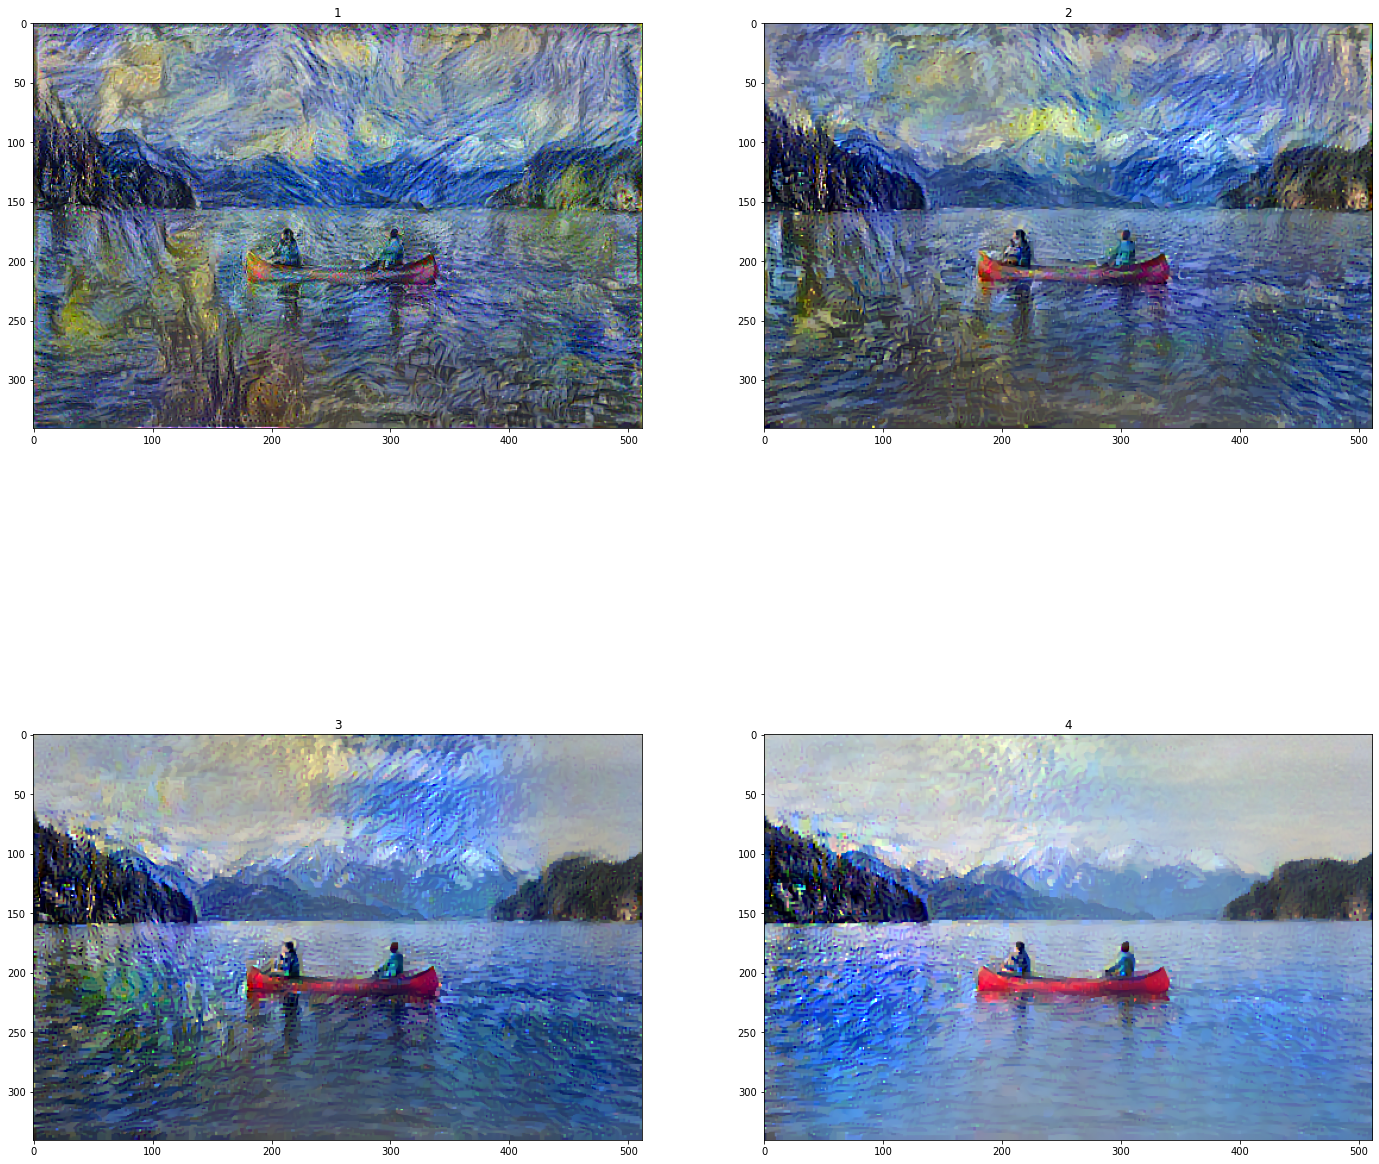

In [ ]:
# 1. style_weight variation
style_weights = [1e-1, 1e-2, 1e-3, 1e-4]

epochs = 10
steps_per_epoch = 100

pos=0
for s_weight in style_weights:
  image = tf.Variable(content_image)
  pos+=1
  for n in range(epochs):
    for m in range(steps_per_epoch):
      with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)for name in style_outputs.keys()] )
        style_loss *= s_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)for name in content_outputs.keys()] )
        content_loss *= content_weight / num_content_layers

        loss = style_loss + content_loss
        loss += total_variation_weight * tf.image.total_variation(image)

      grad = tape.gradient(loss, image)
      opt.apply_gradients([(grad, image)])
      image.assign(normalize(image))

  plt.subplot(2,2,pos)
  imshow(image, pos)


From the result above, we can see that as style weight decreases, more the style applied to the content image (which is very obvious) 

++ 추가적으로 train_step 함수를 이용하지 않고 for loop를 돌렸을 때, 
같은 epoch 과 step을 이용해도 함수를 이용하면 한 사진당 3분, loop로는 한 사진당 5분정도가 소요되었다. 분명 같은 코드임에도 불구하고 차이가 나타나 찾아본 결과, 함수 정의 시 @tf.function이 tf1 스타일로 생성과 실행이 분리되어 작동하기 때문에 성능향상으로 이어진다고 한다. 

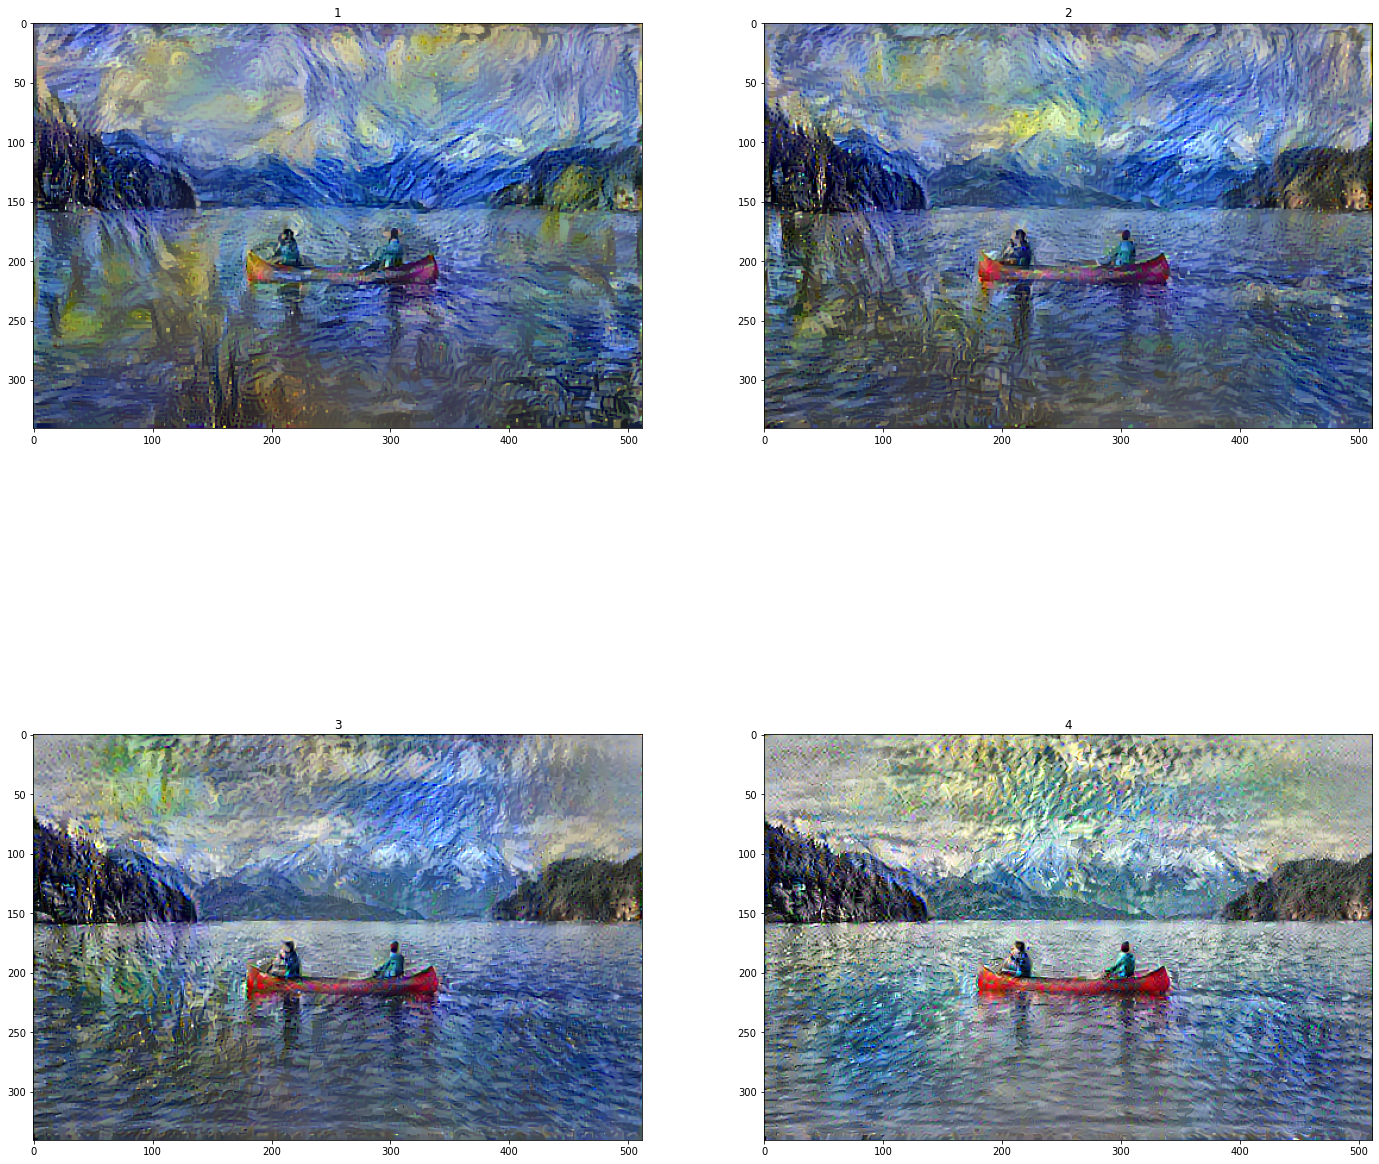

In [ ]:
# 2. content_weight variations
content_weights = [1e3, 1e4, 1e5, 1e6]

epochs = 10
steps_per_epoch = 100

pos=0
for c_weight in content_weights:
  image = tf.Variable(content_image)
  pos+=1
  for n in range(epochs):
    for m in range(steps_per_epoch):
      with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)for name in style_outputs.keys()] )
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)for name in content_outputs.keys()] )
        content_loss *= c_weight / num_content_layers

        loss = style_loss + content_loss
        loss += total_variation_weight * tf.image.total_variation(image)

      grad = tape.gradient(loss, image)
      opt.apply_gradients([(grad, image)])
      image.assign(normalize(image))

  plt.subplot(2,2,pos)
  imshow(image, pos)

From this result, we can see that as content weight increases, less the style applied to the content image (which is also very obvious)

Actually, the style applied to content image depends on the value of content_weight / style_weight 

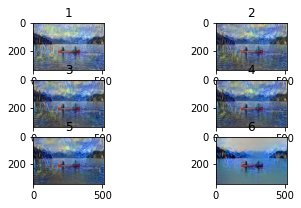

In [ ]:
# 3. total_variation_weight variation

TV_weights = [10, 20, 30, 40, 100, 1000]

epochs = 10
steps_per_epoch = 100

pos=0
for tv_weight in TV_weights:
  image = tf.Variable(content_image)
  pos+=1
  for n in range(epochs):
    for m in range(steps_per_epoch):
      with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)for name in style_outputs.keys()] )
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)for name in content_outputs.keys()] )
        content_loss *= content_weight / num_content_layers

        loss = style_loss + content_loss
        loss += tv_weight * tf.image.total_variation(image)

      grad = tape.gradient(loss, image)
      opt.apply_gradients([(grad, image)])
      image.assign(normalize(image))

  plt.subplot(4,2,pos)
  imshow(image, pos)

From the result above, we can see that as total_variation weight increases, the affect of style on content image decreases. (it is also obvious, since this weight work as regularization)